In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
path = 'Reorgnized_RB.csv'
Russell_data = pd.read_csv(path)

In [13]:
from math import sqrt

# All of the features of interest
selected_inputs = [
    "Min",
    "FGM",
    "FGA",
    "FG%",
    "3PM",
    "3PA",
    "3P%",
    "FTM",
    "FTA",
    "FT%",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PF",
    "+/-",
    "Year",
    "Team score",
    "Season",
    'Lose',
    'Win',
    'Friday',
    'Monday',
    'Saturday',
    'Sunday',
    'Thursday',
    'Tuesday',
    'Wednesday',
    'HOU',
    'LAC',
    'LAL',
    'OKC',
    'WAS',
    'Playoff',
    'Regular'
]

# Split the data into features and score
score = Russell_data["PTS"]
performance = Russell_data[selected_inputs]

performance.head()

,Min,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,...,Thursday,Tuesday,Wednesday,HOU,LAC,LAL,OKC,WAS,Playoff,Regular
0,22.0,4.0,9.0,44.4,1.0,2.0,50.0,4.0,6.0,66.7,...,0,0,1,0,0,0,1,0,0,1
1,19.0,2.0,7.0,28.6,0.0,1.0,0.0,2.0,2.0,100.0,...,0,0,0,0,0,0,1,0,0,1
2,25.0,6.0,13.0,46.2,0.0,1.0,0.0,2.0,3.0,66.7,...,0,0,0,0,0,0,1,0,0,1
3,19.0,4.0,13.0,30.8,3.0,5.0,60.0,2.0,2.0,100.0,...,0,0,1,0,0,0,1,0,0,1
4,17.0,1.0,8.0,12.5,0.0,0.0,0.0,4.0,4.0,100.0,...,0,0,0,0,0,0,1,0,0,1


In [14]:
from sklearn.model_selection import train_test_split

performance_train_data, val_test_data,score_train, score_val_test = train_test_split(performance,score, test_size=0.3)
performance_val_data, performance_test_data, score_val, score_test = train_test_split(val_test_data,score_val_test, test_size= 0.5)

In [15]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

l1_lambdas = np.logspace(-12, 7, 7, base=10)

# Implement code to evaluate LASSO Regression with various L1 penalties
lasso_data = []
for i in l1_lambdas:
  lasso_model = Lasso(alpha=i)
  lasso_model.fit(performance_train_data, score_train)
  predictions_train = lasso_model.predict(performance_train_data)
  predictions_validation = lasso_model.predict(performance_val_data)
  lasso_data.append({
        'l1_penalty': i,
        'model':lasso_model,
        'rmse_train':mean_squared_error(predictions_train, score_train, squared=False),
        'rmse_validation':mean_squared_error(predictions_validation, score_val, squared=False)
    })
lasso_data = pd.DataFrame(lasso_data)
lasso_data

,l1_penalty,model,rmse_train,rmse_validation
0,1.000000e-12,Lasso(alpha=1e-12),0.005846,0.006227
1,1.467799e-09,Lasso(alpha=1.4677992676220676e-09),0.005846,0.006227
2,2.154435e-06,Lasso(alpha=2.1544346900318822e-06),0.005840,0.006215
3,3.162278e-03,Lasso(alpha=0.0031622776601683794),0.004431,0.004504
4,4.641589e+00,Lasso(alpha=4.641588833612772),2.334605,2.338104
5,6.812921e+03,Lasso(alpha=6812.9206905795945),9.119127,9.273118
6,1.000000e+07,Lasso(alpha=10000000.0),9.119127,9.273118


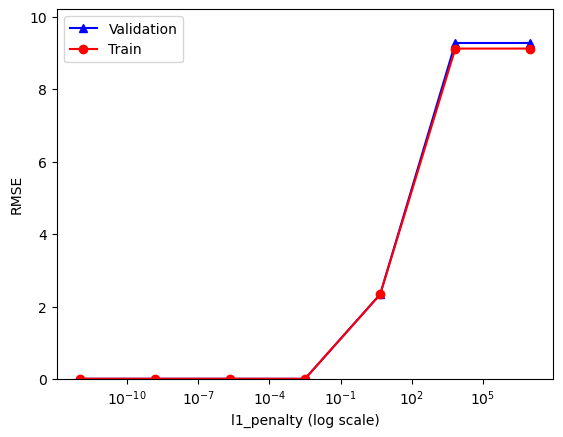

In [16]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_validation'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_train'],
         'r-o', label='Train')

# Set y-limits
rmse_max = max(lasso_data['rmse_train'].max(), lasso_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

In [17]:
# Print information about best L1 model

index = lasso_data['rmse_validation'].idxmin()
row = lasso_data.loc[index]
best_l1 = row['l1_penalty']


lasso_model_test = Lasso(alpha=best_l1)
lasso_model_test.fit(performance_train_data, score_train)
predictions_test = lasso_model_test.predict(performance_test_data)
rmse_test_lasso = mean_squared_error(predictions_test, score_test, squared=False)

count = 0
for num in lasso_model_test.coef_:
  if num == 0:
    count += 1
num_zero_coeffs_lasso = count

# Print your results to help you check their correctness.
print('Best L1 Penalty', best_l1)
print('Test RMSE', rmse_test_lasso)
print('Num Zero Coeffs', num_zero_coeffs_lasso)

Best L1 Penalty 0.0031622776601683794
Test RMSE 0.003848655823335424
Num Zero Coeffs 29


In [18]:
best_model_lasso = lasso_model_test

zero_coef_features = []
nonzero_coef_features = []
for feature, coef in zip(selected_inputs, best_model_lasso.coef_):
  if abs(coef) <= 10 ** -17:
    zero_coef_features.append(feature)
  else:
    nonzero_coef_features.append(feature)

print("Features with coefficient == 0:", zero_coef_features)
print("Features with coefficient != 0:", nonzero_coef_features)

Features with coefficient == 0: ['Min', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'Year', 'Team score', 'Season', 'Lose', 'Win', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'HOU', 'LAC', 'LAL', 'OKC', 'WAS', 'Playoff', 'Regular']
Features with coefficient != 0: ['FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%']


In [19]:
def print_coefficients(model, features):
    """
    This function takes in a model and a features column.
    And prints the coefficient along with its feature name.
    """
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef}")

print_coefficients(lasso_model_test, selected_inputs)

Min: 0.0
FGM: 1.999881798173532
FGA: 5.1873293895137945e-05
FG%: 5.753530105465781e-05
3PM: 0.9922032151211349
3PA: 0.0018828419672521812
3P%: 0.00020913104487040303
FTM: 0.9994897576032004
FTA: 0.00023439353875829696
FT%: 1.4214195872878928e-05
OREB: -0.0
DREB: 0.0
REB: 0.0
AST: 0.0
STL: 0.0
BLK: -0.0
TOV: 0.0
PF: -0.0
+/-: 0.0
Year: -0.0
Team score: 0.0
Season: -0.0
Lose: 0.0
Win: -0.0
Friday: 0.0
Monday: -0.0
Saturday: -0.0
Sunday: -0.0
Thursday: 0.0
Tuesday: -0.0
Wednesday: 0.0
HOU: -0.0
LAC: -0.0
LAL: -0.0
OKC: 0.0
WAS: 0.0
Playoff: -0.0
Regular: 0.0
